In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as cst
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy.modeling.models import BlackBody
import pandas as pd
import healpy as hp
import numpy as np
import scipy as sp
from sympy import Matrix
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import fixed_quad
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
import glob
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)
#matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams.update({'figure.autolayout': True})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#  $\underline{\rm 0- ~Cosmology}$

In [2]:
# Planck cosmo 2018 | TT,TE,EE+lowE+lensing+BAO
h = 0.6898
Om = 0.2905
Ov = 0.7095
sig8 = 0.8260
ns = 0.9690
#Ob_h2 = 0.02242
Ob = 0.0473
#Oc_h2 = 0.11933
#Oc = Oc_h2/h**2
b_ia = 0.5
B_amp = 3.13

In [3]:
omegam_0 = Om
cosmo = FlatLambdaCDM(H0=68.98, Om0=omegam_0,Ob0=0)

In [4]:
cosmo.Om0,cosmo.Ode0,cosmo.Ob0,cosmo.Ogamma0,cosmo.Onu0

(0.2905, 0.7095, 0.0, 0.0, 0.0)

In [5]:
def E(z,omega_m,omega_l):
    E_of_z = np.sqrt(omega_m*(1+z)**3+omega_l)
    return E_of_z

# $\underline{\rm 1- ~Calculate ~the ~BNT ~matrix ~from ~the ~n(z)}$

###  Read the n(z) in bins and calculate $n_i^{(0)}$ and $n_i^{(1)}$

$w_i(\chi)=\frac{3\Omega_0H_0^2}{2c^2} \int_{\rm bin_i}{\rm d}z n(z)\frac{f_K(\chi(z)-\chi)f_K(\chi)}{f_K(\chi(z))}\frac{1}{a(\chi)}$

$n_i^{(0)}=\int_{\rm bin ~i}{\rm d}\chi n(\chi)$

$n_i^{(1)}=\int_{\rm bin ~i}{\rm d}\chi n(\chi)\xi_K(\chi)$

In [6]:
def n_0_i_int(z,n_of_z_interp):
    return n_of_z_interp(z)

def n_1_i_int(z,n_of_z_interp):
    chi_of_z = (cosmo.comoving_distance(z)/(cst.c/cosmo.H0)).cgs
    n_1_i_int = n_of_z_interp(z)/chi_of_z
    return n_1_i_int

### 1-1 With separate n(z) files

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,6.709678,2.757165,2.067182,1.700346,1.45697,1.275822,1.130408,1.005129,0.888099,0.759146


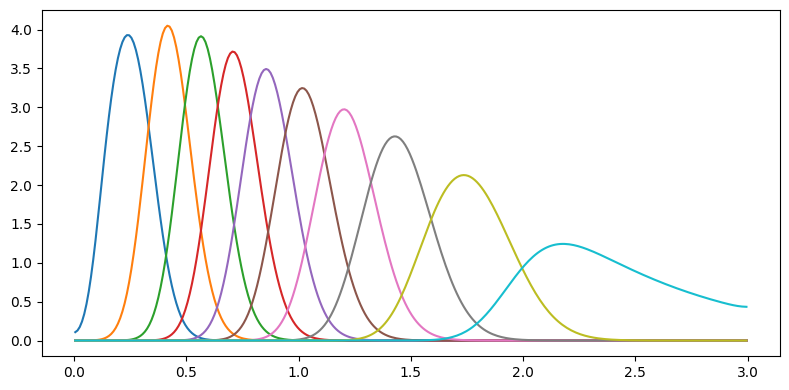

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

ntomobin = 10
nzrows = 300
nz_table = np.zeros((nzrows,ntomobin+1))

file_path = 'nofz_SLICS_LSST_bin'
n_0 = np.zeros(ntomobin)
n_1 = np.zeros(ntomobin)

for i in range(ntomobin):
    file_data = np.loadtxt(file_path+str(i+1)+'.dat', skiprows=2)
    #z_list = file_data[:,0]
    #f_list = file_data[:,3]
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,3]
    plt.plot(nz_table[:,0],nz_table[:,i+1])

    n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    
    zmin=1e-18
    zmax=3
    n_0[i], error = fixed_quad(n_0_i_int, zmin, zmax,args=(n_of_z_interp,),n=10000)
    n_1[i], error = fixed_quad(n_1_i_int, zmin, zmax, args=(n_of_z_interp,),n=10000)
        
pd.DataFrame([n_0,n_1])

### 1-2 All n(z) in one file

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,6.709678,2.757165,2.067182,1.700346,1.45697,1.275822,1.130408,1.005129,0.888099,0.759146


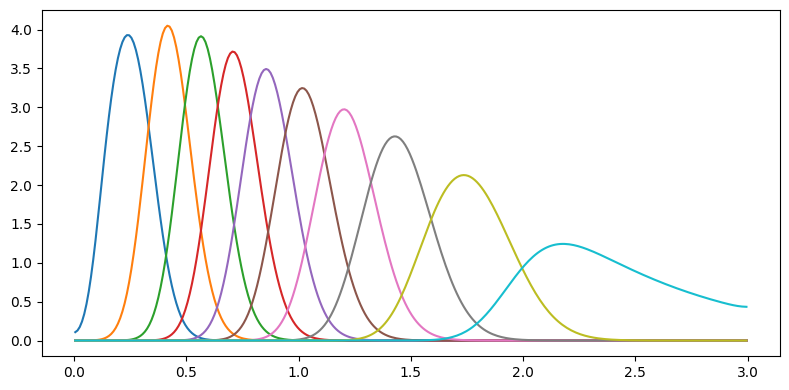

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

#nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_lssty1.nz'
nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_LSST_10bins.dat'
file_data = np.loadtxt(nz_path)

nzrows = file_data.shape[0]
ntomobin = file_data.shape[1]-1

#ntomobin = 5
#nzrows = 300

nz_table = np.zeros((nzrows,ntomobin+1))
n_0 = np.zeros(ntomobin)
n_1 = np.zeros(ntomobin)


for i in range(ntomobin):
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,i+1]
    
    zmin=1e-18
    zmax=3
    n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    n_0[i], error = fixed_quad(n_0_i_int, zmin, zmax,args=(n_of_z_interp,),n=10000)
    n_1[i], error = fixed_quad(n_1_i_int, zmin, zmax, args=(n_of_z_interp,),n=10000)       
    
    plt.plot(nz_table[:,0],nz_table[:,i+1])

pd.DataFrame([n_0,n_1])

## Calculate the BNT matrix

In [8]:
p_a_i = np.zeros((ntomobin,ntomobin))
p_a_i[1,0] = -1
for i in range(ntomobin):
    p_a_i[i,i] = 1

In [9]:
for i in range(2,ntomobin):
    print(i)
    p_a_i[i,i-2] = (n_1[i]*n_0[i-1]-n_0[i]*n_1[i-1])/(n_0[i-2]*n_1[i-1]-n_1[i-2]*n_0[i-1])
    p_a_i[i,i-1] = (n_1[i]*n_0[i-2]-n_0[i]*n_1[i-2])/(n_0[i-1]*n_1[i-2]-n_1[i-1]*n_0[i-2])

2
3
4
5
6
7
8
9


In [10]:
Mat_p_a_i = Matrix(p_a_i)
Mat_p_a_i

Matrix([
[              1.0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[             -1.0,               1.0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[0.174568273835669, -1.17456833734345,               1.0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[                0, 0.531660190483591, -1.53166019181256,               1.0,                 0,                 0,                 0,                 0,                 0,   0],
[                0,                 0, 0.663443582465118, -1.66344358238735,               1.0,                 0,                 0,                 0,                 0,   0],
[                0,                 0,                 0, 0.744314547503051, -1.74431454755849,      

In [11]:
p_a_i[3,1]

0.5316601904835908

### Checking unity

In [12]:
Mat_p_a_i_inv = Mat_p_a_i.inv()
Mat_p_a_i_inv*Mat_p_a_i

Matrix([
[                  1.0,                     0,                     0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[-1.11022302462516e-16,                   1.0,                     0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[-1.38777878078145e-16,                     0,                   1.0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[ 1.11022302462516e-16, -2.22044604925031e-16,                     0,                   1.0,                     0,                     0,                    0,                     0,   0,   0],
[-5.55111512312578e-17, -4.44089209850063e-16, -1.11022302462516e-16, -2.22044604925031e-16,                   1.0,                     0,                    0,                     0,   0,   0],
[ 5.551115123125

### Calculate the $P_A^{~~I}$ matrix

$n_{\rm tomo}$ is the number of redshift bins.

$(i,j)$ are pairs of redshift bins. $\xi_{ij}^{+/-}(\theta_k)$ are the tomographic shear correlation functions between redshift bins $i$ and $j$ at scale $\theta_k$.

$p_{ai}$ is the BNT matrix. Its size is $n_{\rm tomo} \times n_{\rm tomo}$.

The BNT transform $\xi\rightarrow\hat\xi$ is:
<div style="text-align: center">
$\hat \xi_{ab}^{+/-}(\theta_k) = \sum_{ij} p_{ai}p_{bj}\xi_{ij}^{+/-}(\theta_k)$
</div>

The number of distincts $(i,j)$ pairs is $\frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$.

Ordering before BNT:

**inner loop is over tomo bin pairs**

**intermediate loop is over $\theta_k$ scales**

**outer loop is over** $+$ **and** $-$

<div style="text-align: center">
$V_{I}=\begin{pmatrix}
    \begin{array}{cc}
        \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^+ (\theta_0) \\
       \begin{array}{c}
        &&&. \\
        &&&. \\
       \end{array} \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^+ (\theta_n) \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^- (\theta_0) \\
       \begin{array}{c}
        &&&. \\
        &&&. \\
       \end{array} \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^- (\theta_n) \\
    \end{array}
\end{pmatrix}
$
</div>

The BNT transform on the data vector $V_I$:

<div style="text-align: center">
    $\hat V_A=P_A^{~~I}V_I$
</div>

Where the $P_A^{~~I}$ matrix is

<div style="text-align: center">
$P_A^{~~I} = \begin{pmatrix}
    \begin{array}{cc}
        \begin{bmatrix}
        P_A^{~~I} ~{\rm block}\\
       \end{bmatrix} & & 0 \\
        & \begin{bmatrix}
        ...... \\
       \end{bmatrix} &  \\
       0 & & \begin{bmatrix}
        P_A^{~~I} ~{\rm block} \\
       \end{bmatrix} \\
    \end{array}
\end{pmatrix}
$
</div>

Size of $\left[P_A^{~~I} ~{\rm block}\right]$ is $\frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$

Size of $P_A^{~~I}$ is $2n_\theta \frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$

### Calculate the $ (i,j) \rightarrow I$ index convertion to calculate $\left[ P_A^{~~I} ~{\rm block}\right]$

In [13]:
my_dict = {}
icpt = 0
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        new_z_bin = {icpt:np.array((iz-1,jz-1))}
        my_dict.update(new_z_bin)
        #print(new_z_bin)
        icpt += 1

In [14]:
#my_dict

In [15]:
ntomoindex = int(ntomobin*(1+ntomobin)/2)
P_AI_block = np.zeros((ntomoindex,ntomoindex))

for A in range(1,ntomoindex+1):
    for I in range(1,ntomoindex+1):
        P_AI_block[A-1,I-1] = p_a_i[my_dict[A-1][1],my_dict[I-1][1]]*p_a_i[my_dict[A-1][0],my_dict[I-1][0]]
        if (my_dict[I-1][1] > my_dict[I-1][0]):
            P_AI_block[A-1,I-1] = P_AI_block[A-1,I-1] + p_a_i[my_dict[A-1][1],my_dict[I-1][0]]*p_a_i[my_dict[A-1][0],my_dict[I-1][1]]

/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


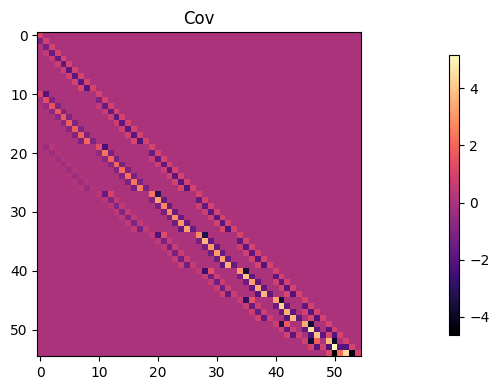

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))

im = axs.imshow(P_AI_block,cmap='magma')#,norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Save and plot $\left[ P_A^{~~I} ~{\rm block}\right]$

In [17]:
hdu = fits.PrimaryHDU(P_AI_block)
hdul = fits.HDUList([hdu])
fits_filename = "Pai_55x55.fits"
hdul.writeto(fits_filename, overwrite=True)

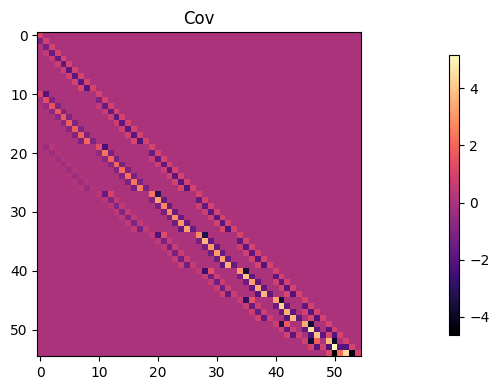

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))

im = axs.imshow(P_AI_block,cmap='magma')#,norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Calculate the full $P_A^{~~I}$ from $\left[ P_A^{~~I} ~{\rm block}\right]$

In [19]:
n_theta = 20  #  number of theta scales
ntomoindex = int(ntomobin*(1+ntomobin)/2)
n_xi = n_theta*ntomoindex
n_P_AI = 2*n_theta*ntomoindex
P_AI = np.zeros((n_P_AI,n_P_AI))
ntomoindex,n_P_AI/2

(55, 1100.0)

In [20]:
for itheta in range(n_theta):
    i = itheta*ntomoindex
    #print(itheta,itheta+ntomoindex)
    #print(n_theta*ntomoindex+itheta,n_theta*ntomoindex+itheta+55)
    P_AI[i:(i+ntomoindex),i:(i+ntomoindex)] = P_AI_block
    P_AI[n_xi+i:(n_xi+i+ntomoindex),n_xi+i:(n_xi+i+ntomoindex)] = P_AI_block

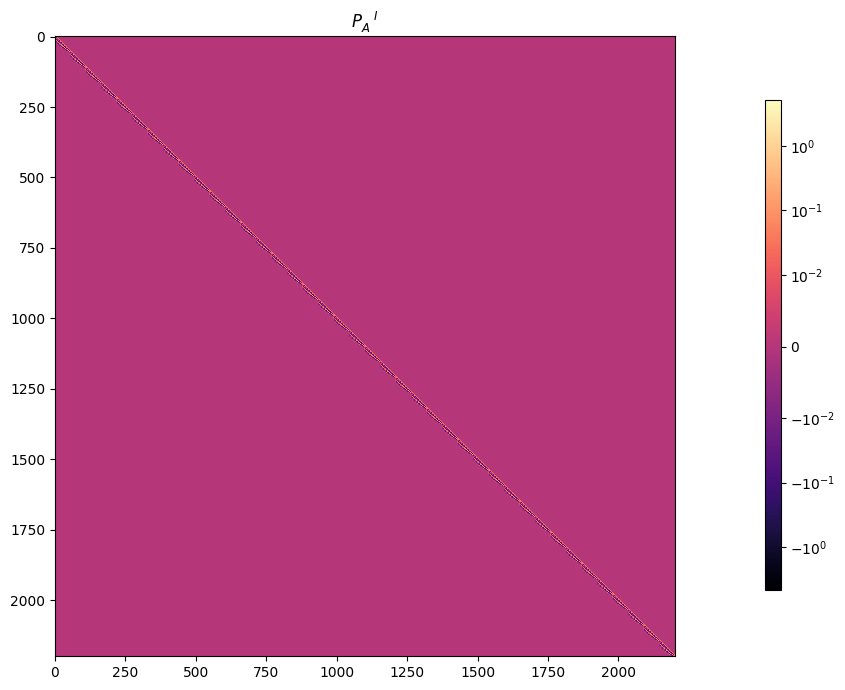

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(8,7))

im = axs.imshow(P_AI,cmap='magma',norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("$P_A^{~~~I}$")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Make $w_i(z)$ and $w_a(z)$ kernel plots

In [22]:
def kernel_int(zp,z,n_of_z_interp):
    chi_of_zp = (cosmo.comoving_distance(zp)/(cst.c/cosmo.H0)).cgs
    chi_of_z = (cosmo.comoving_distance(z)/(cst.c/cosmo.H0)).cgs
    kernel_int = (1+z)*n_of_z_interp(zp)*(chi_of_zp-chi_of_z)*chi_of_z/chi_of_zp
    return kernel_int

def kernel(z,n_of_z_interp):
    zpmin = z
    zpmax = 3.
    result, error = fixed_quad(kernel_int, zpmin, zpmax, args=(z,n_of_z_interp),n=10000)
    return result

vectorized_kernel = np.vectorize(kernel, excluded=['n_of_z_interp'])

0
1
2
3
4
5
6
7
8
9


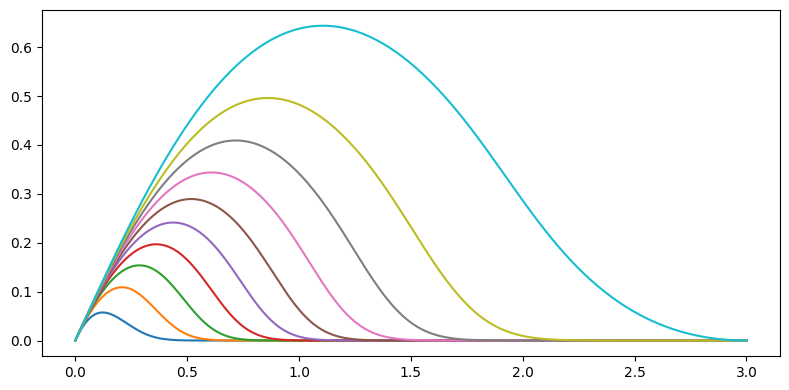

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

n_z_sample = 200  #  number of sampling points for n(z) plots
z_sample = np.linspace(0, 3, n_z_sample)
w_i_table = np.zeros((n_z_sample,ntomobin))

for i in range(ntomobin):
    print(i)
    z_list = nz_table[:,0]
    f_list = nz_table[:,i+1]
    n_of_z_interp = interp1d(z_list, f_list, kind='quadratic',fill_value='extrapolate')
    
    w_i_table[:,i] = vectorized_kernel(z_sample,n_of_z_interp)
    
    plt.plot(z_sample,w_i_table[:,i])   

In [24]:
w_a_table = np.zeros((n_z_sample,ntomobin))
for a in range(ntomobin):
    for i in range(ntomobin):
        #print(a,i,p_a_i[a,i])
        w_a_table[:,a] = w_a_table[:,a]+p_a_i[a,i]*w_i_table[:,i]

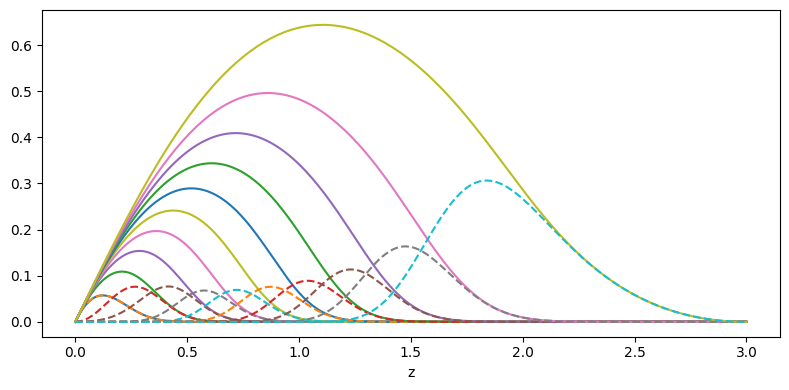

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for a in range(ntomobin):
    plt.plot(z_sample,w_i_table[:,a])   
    plt.plot(z_sample,w_a_table[:,a],linestyle='--')
    plt.xlabel('z')
    #plt.yscale('log')
    #plt.ylim([1e-18,1e-10])

## Read CCL and BNT ordering covariance matrix

In [26]:
hdu1 = fits.open('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/covariance_cosmocov_CCL_10zbins_20theta.fits')
covmat_CCL = hdu1[0].data
hdu1.close()
cov_inv_CCL = np.linalg.inv(covmat_CCL)
cov_inv_CCL @ covmat_CCL

array([[ 1.00000000e+00,  4.46412833e-20, -2.80623091e-20, ...,
        -4.18023994e-20, -2.79653221e-20,  6.95493459e-20],
       [-1.52921087e-19,  1.00000000e+00, -7.53855187e-20, ...,
        -5.72408984e-21, -5.75585357e-20, -9.99498878e-20],
       [ 2.41031952e-19,  1.27773762e-19,  1.00000000e+00, ...,
         1.94089659e-20,  5.16425400e-20,  1.15725876e-19],
       ...,
       [ 6.15826834e-17,  6.93889390e-17,  7.97972799e-17, ...,
         1.00000000e+00,  1.11022302e-15,  1.38777878e-15],
       [-2.94902991e-17, -3.46944695e-18, -3.29597460e-17, ...,
        -2.22044605e-16,  1.00000000e+00,  0.00000000e+00],
       [-4.33680869e-17, -7.80625564e-17, -1.11022302e-16, ...,
         2.22044605e-16, -4.44089210e-16,  1.00000000e+00]])

In [27]:
hdu2 = fits.open('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/covariance_cosmocov_BNT_10zbins_20theta.fits')
covmat_BNT_order = hdu2[0].data

#. apply the BNT transfor to the BNT ordered covariance matrix
#covmat_BNT = np.einsum('ai,bj,ij->ab',P_AI,P_AI,covmat_BNT_order)
covmat_BNT = P_AI @ np.transpose(P_AI @ np.transpose(covmat_BNT_order))

In [29]:
cov_inv_BNT = np.linalg.inv(covmat_BNT)
cov_inv_BNT @ covmat_BNT

array([[ 1.00000000e+00, -3.65530380e-10,  5.27667485e-10, ...,
         6.25559828e-14, -2.40112154e-14, -6.68441598e-15],
       [ 3.67521266e-10,  9.99999999e-01,  1.30589384e-09, ...,
         1.51484012e-13, -5.11742698e-14, -2.38066398e-14],
       [ 4.89053526e-10, -1.23816072e-09,  1.00000000e+00, ...,
         1.84249479e-13, -4.96150597e-14, -4.67543671e-14],
       ...,
       [-3.02313730e-13, -1.50809920e-13,  1.23116795e-12, ...,
         1.00000000e+00, -6.14786000e-14,  1.40568113e-13],
       [-1.93806776e-13, -9.20583054e-14,  7.54632468e-13, ...,
         3.18370330e-13,  1.00000000e+00, -6.55031585e-15],
       [-3.12866053e-14, -1.33660444e-14,  1.13796125e-13, ...,
         3.52834081e-14,  5.21648696e-14,  1.00000000e+00]])

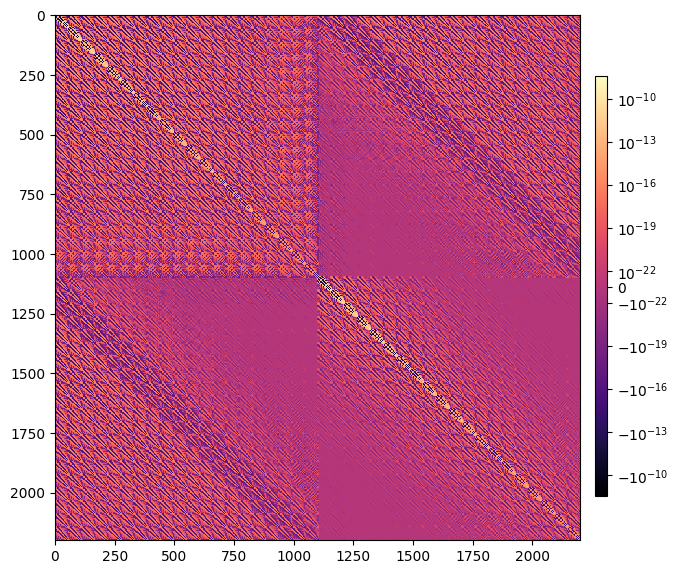

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

im = axs.imshow(covmat_BNT,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-22))
#axs.set_title("Correlation BNT ordering")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Calculate eigenvalues

In [31]:
U_ccl, S_ccl, Vh_ccl = sp.linalg.svd(covmat_CCL , full_matrices=True)
S_ccl_inv = 1/S_ccl
inverse_CCL = np.dot(Vh_ccl.T, np.dot(np.diag(S_ccl_inv), U_ccl.T))

In [32]:
U_bnt, S_bnt, Vh_bnt = sp.linalg.svd(covmat_BNT, full_matrices=True)
S_bnt_inv = 1/S_bnt
inverse_BNT = np.dot(Vh_bnt.T, np.dot(np.diag(S_bnt_inv), U_bnt.T))

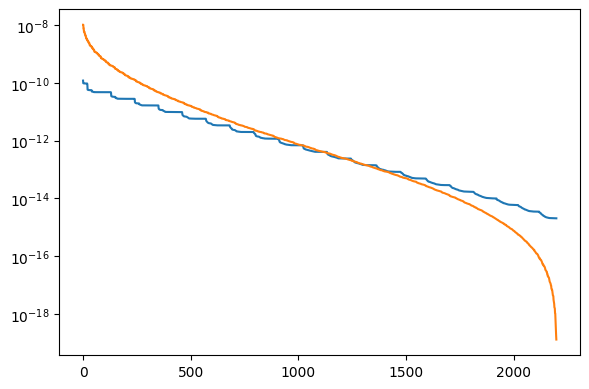

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(S_ccl)
plt.plot(S_bnt)
plt.yscale('log')

## Read CCL and BNT data vectors

In [34]:
data_theta = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/data_vector_20theta.npy')

In [35]:
data_ccl = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/data_vector_CCL_10zbins_20theta.npy')

In [36]:
data_bnt_ordering = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/data_vector_BNT_10zbins_20theta.npy')
data_bnt = P_AI @ data_bnt_ordering

##  $\chi^2$ tests using CCL and BNT matrices and model vectors

In [37]:
data_ccl @ cov_inv_CCL @ data_ccl

247189.44876371452

In [38]:
data_bnt_ordering @ np.linalg.inv(covmat_BNT_order) @ data_bnt_ordering

247189.44876371435

In [39]:
data_bnt @ cov_inv_BNT @ data_bnt

247189.44876106468

In [134]:
model1_theta = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model1_vector_20theta.npy')
model1_ccl = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model1_vector_CCL_10zbins_20theta.npy')
model1_bnt_ordering = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model1_vector_BNT_10zbins_20theta.npy')
model1_bnt = P_AI @ model1_bnt_ordering

model2_theta = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model2_vector_20theta.npy')
model2_ccl = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model2_vector_CCL_10zbins_20theta.npy')
model2_bnt_ordering = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model2_vector_BNT_10zbins_20theta.npy')
model2_bnt = P_AI @ model2_bnt_ordering

model3_theta = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model3_vector_20theta.npy')
model3_ccl = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model3_vector_CCL_10zbins_20theta.npy')
model3_bnt_ordering = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/model3_vector_BNT_10zbins_20theta.npy')
model3_bnt = P_AI @ model3_bnt_ordering

In [135]:
(data_ccl-model1_ccl) @ cov_inv_CCL @ (data_ccl-model1_ccl)

6.003346799715774

In [137]:
(data_bnt-model1_bnt) @ cov_inv_BNT @ (data_bnt-model1_bnt)

6.003346799651345

In [138]:
(data_ccl-model2_ccl) @ cov_inv_CCL @ (data_ccl-model2_ccl)

24.147174434370395

In [139]:
(data_bnt-model2_bnt) @ cov_inv_BNT @ (data_bnt-model2_bnt)

24.147174434115037

In [140]:
(data_ccl-model3_ccl) @ cov_inv_CCL @ (data_ccl-model3_ccl)

54.36246265540576

In [141]:
(data_bnt-model3_bnt) @ cov_inv_BNT @ (data_bnt-model3_bnt)

54.36246265479743

### Various plots and $\chi^2$ tests

In [124]:
def masterplot_xi(xip,xim,xip_err,xim_err,ntomobin,theta_values):
    text_width = 10
#column_width = 256.0748/72
    tick_spacing = 2
    fig,axes= plt.subplots(ntomobin+1,ntomobin+2,figsize=(text_width, text_width*0.75),gridspec_kw={'hspace': 0, 'wspace': 0})

# Blank out the empty cells
    for i in range(ntomobin+1):
        blankgrid=ntomobin-i+1
        axes[i,blankgrid].set_visible(False)
        axes[i,blankgrid-1].set_visible(False)

    xvalues = theta_values
# plots range
    xmin,xmax = xvalues.min(),xvalues.max()
    fact = 1.
    #ypmin,ypmax = [1e-7,1e-3]
    #ymmin,ymmax = [1e-8,1e-4]
    ypmin,ypmax = [1e-11,1e-5]
    ymmin,ymmax = [1e-11,1e-4]

    for iz in range(1,ntomobin+1):
        for jz in range(iz,ntomobin+1):

        # tomographic bin combination
            tomochar='%s-%s'%(iz,jz)
        
        # -------- TOP SUBPLOTS -------
        # find tomographic grid cell in top subplots
            gridcell_x_top=(iz-1)
            gridcell_y_top=(ntomobin-jz)
            ax=axes[gridcell_y_top,gridcell_x_top]
        
        # load yvalues
            yvalues = xip[iz-1,jz-1,:]
            yerr = xip_err[iz-1,jz-1,:]
        # plot (xvalues,yvalues)
            #ax.plot(xvalues,yvalues,color='m',linewidth=1.5)
            ax.errorbar(xvalues,yvalues,yerr=yerr,color='m',linewidth=1.5)
        
        # only label the subplots at the edges
            ax.label_outer()
        # and then override for the autocorrelations
            if iz==jz:
                ax.xaxis.tick_bottom()
                if iz==1:
                    ax.set_xlabel('$\\theta$')
        
        # add the tomographic bin combination
            ax.annotate(tomochar, xy=(0.95,0.9),xycoords='axes fraction',size=8, ha='right', va='top')
            ax.axhline(y=0, color='black', ls=':')
        
        # set the limits of the plot
            ax.set_xscale('log')
            ax.set_xlim(xmin,xmax)
            ax.set_yscale('log')
            ax.set_ylim(ypmin,ypmax)
        
        # -------- BOTTOM SUBPLOTS -------
        # find tomographic grid cell in bottom subplots
            gridcell_x_bottom=(jz+1)
            gridcell_y_bottom=(ntomobin+1-iz)
            ax=axes[gridcell_y_bottom,gridcell_x_bottom]
        # load yvalues
            yvalues = xim[iz-1,jz-1,:]
            yerr = xim_err[iz-1,jz-1,:]
        # plot (xvalues,yvalues)
            #ax.plot(xvalues,yvalues,color='m',linewidth=1.5)
            ax.errorbar(xvalues,yvalues,yerr=yerr,color='m',linewidth=1.5)
        
        # only label the subplots at the edges
            ax.label_outer()
        # and then override for the bin 5 left column
            if jz==ntomobin:
                ax.yaxis.tick_right()
            if ((iz==1) and (jz==1)):
                ax.set_xlabel('$\\theta$')

        # add the tomographic bin combination and a horizontal line
            ax.annotate(tomochar, xy=(0.95,0.9),xycoords='axes fraction',size=10, ha='right', va='top')
            ax.axhline(y=0, color='black', ls=':')
        
        # set the limits of the plot
            ax.set_xscale('log')
            ax.set_xlim(xmin,xmax)
            ax.set_yscale('log')
            ax.set_ylim(ymmin,ymmax)

### Rearrange the CCL format vector in a 3D array for mosaic plots

In [101]:
xi_errors_ccl = np.sqrt(np.diag(covmat_CCL))

In [102]:
xip_full_ccl = np.zeros((ntomobin,ntomobin,n_theta))
xim_full_ccl = np.zeros((ntomobin,ntomobin,n_theta))

xip_err_ccl = np.zeros((ntomobin,ntomobin,n_theta))
xim_err_ccl = np.zeros((ntomobin,ntomobin,n_theta))

kcpt = 0
kshift = int(n_theta*ntomobin*(1+ntomobin)/2)
for ik in range(ntomobin):
    for jk in range(ik,ntomobin):
        xip_full_ccl[ik,jk,:] = data_ccl[kcpt*n_theta:(kcpt+1)*n_theta]
        xip_err_ccl[ik,jk,:] = xi_errors_ccl[kcpt*n_theta:(kcpt+1)*n_theta]
        xim_full_ccl[ik,jk,:] = data_ccl[kshift+kcpt*n_theta:kshift+(kcpt+1)*n_theta]
        xim_err_ccl[ik,jk,:] = xi_errors_ccl[kshift+kcpt*n_theta:kshift+(kcpt+1)*n_theta]
        kcpt += 1

### Rearrange the BNT format vector in a 3D array for mosaic plots

In [103]:
xi_errors_bnt = np.sqrt(np.diag(covmat_BNT))

In [104]:
xip_full_bnt = np.zeros((ntomobin,ntomobin,n_theta))
xim_full_bnt = np.zeros((ntomobin,ntomobin,n_theta))

xip_err_bnt = np.zeros((ntomobin,ntomobin,n_theta))
xim_err_bnt = np.zeros((ntomobin,ntomobin,n_theta))

ntomo_tot = int(ntomobin*(1+ntomobin)/2)
kshift = int(n_theta*ntomobin*(1+ntomobin)/2)
for itheta,theta_val in enumerate(data_theta):
    icpt = 0
    for iz in range(ntomobin):
        for jz in range(iz,ntomobin):
            xip_full_bnt[iz,jz,itheta] = data_bnt[icpt+itheta*ntomo_tot]
            xip_err_bnt[iz,jz,itheta] = xi_errors_bnt[icpt+itheta*ntomo_tot]
            xim_full_bnt[iz,jz,itheta] = data_bnt[kshift+icpt+itheta*ntomo_tot]
            xim_err_bnt[iz,jz,itheta] = xi_errors_bnt[kshift+icpt+itheta*ntomo_tot]
            #print(iz,jz,icpt,itheta,'|',icpt+itheta*ntomo_tot,data_bnt_ordering[icpt+itheta*ntomo_tot])
            icpt += 1

### Mosaic plots

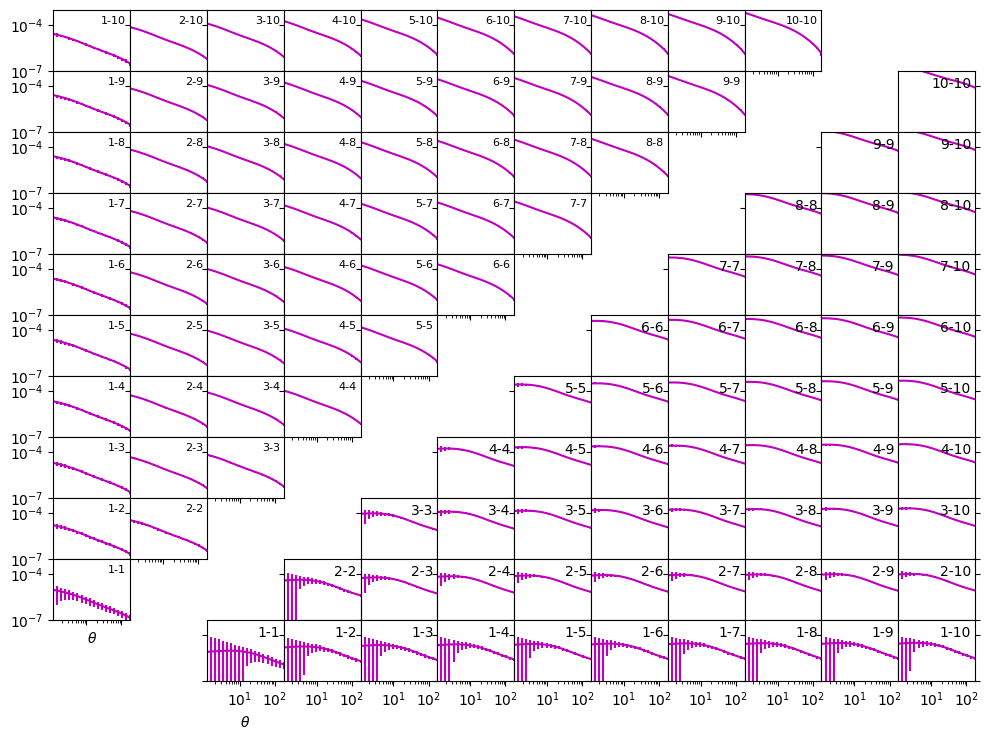

In [113]:
masterplot_xi(xip_full_ccl,xim_full_ccl,xip_err_ccl,xim_err_ccl,ntomobin,data_theta)

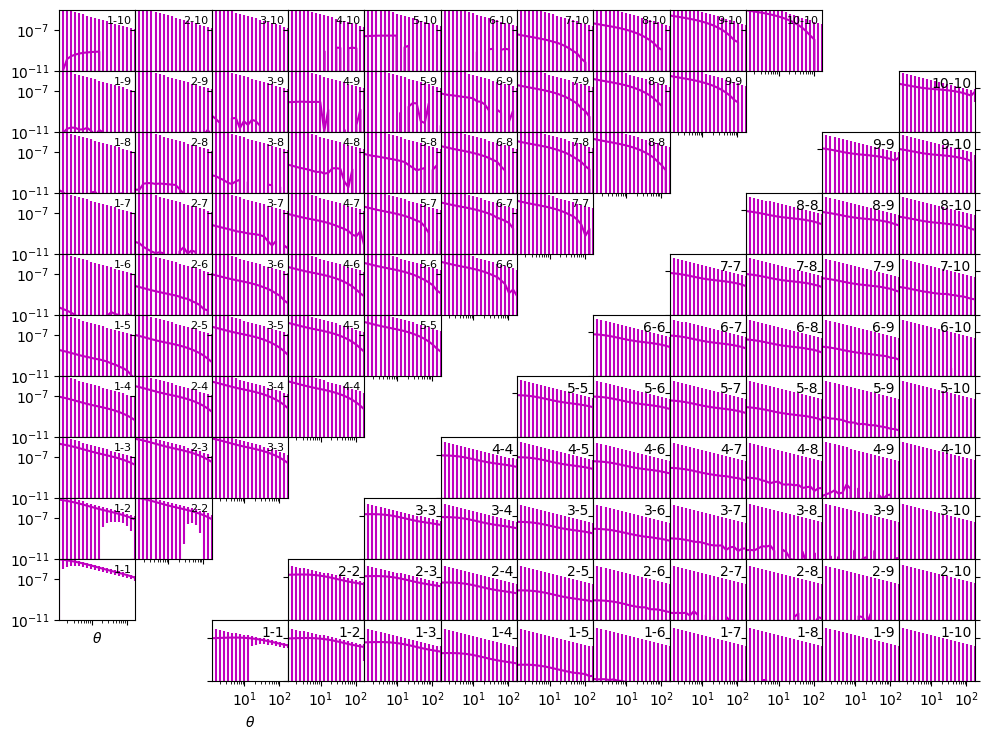

In [125]:
masterplot_xi(xip_full_bnt,xim_full_bnt,xip_err_bnt,xim_err_bnt,ntomobin,data_theta)